In [35]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.patheffects as path_effects

import os,glob,copy
import numpy as np
import squarify

import os, csv, numpy as np, pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
import seaborn as sns
import geopandas as gpd

typeface='Helvetica Neue'
mpl.rcParams['mathtext.fontset']='custom'
mpl.rcParams['font.sans-serif']=typeface
mpl.rcParams['mathtext.default']='sf'
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

base_path='/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/' ## where contig_quality and contig folders sit

# --- 1) Read metadata keyed by NewIDseqName ---
metadata = {}
meta_path = os.path.join(base_path, 'Metada_annotated.csv')
with open(meta_path, 'r') as f:
    header = [h.strip() for h in f.readline().strip('\r\n').split(',')]
    idx = {h: i for i, h in enumerate(header)}
    key_col = 'NewIDseqName'  # <-- change if your header uses a different name
    for line in f:
        l = line.strip('\r\n').split(',')
        if len(l) != len(header):
            continue
        key = l[idx[key_col]].strip()
        metadata[key] = {h: l[idx[h]].strip() for h in header}


In [36]:
import os

decontam = {}

# Process 'contig_calls1.tsv'
with open(os.path.join(base_path, 'contig_calls_decontam.tsv'), 'r') as file:
    for line in file:
        l = line.strip('\n').split('\t')
        if l[0] == 'sample':
            header = {x: i for i, x in enumerate(l)}  # Create header dict
        else:
            sample = l[header['sample']]
            contig_name = l[header['contig_name']]
            
            # Handle empty 'read_count'
            read_count_str = l[header['read_count']].strip()
            if read_count_str:
                read_count = int(float(read_count_str))
            else:
                read_count = 0  # Assign default value or handle as needed
            
            if sample not in decontam:
                decontam[sample] = set()
            
            decontam[sample].add(contig_name)

contig_classification = {}
contam = {}

# Process '2contig_calls.tsv'
with open(os.path.join(base_path, 'contig_calls.tsv'), 'r') as file:
    for line in file:
        l = line.strip('\n').split('\t')
        if l[0] == 'sample':
            header = {x: i for i, x in enumerate(l)}  # Create header dict
        elif 'water' not in l[header['sample']].lower():  # Ignore water samples
            sample = l[header['sample']]
            if sample not in contig_classification:
                contig_classification[sample] = {}
            
            if sample not in contam:
                contam[sample] = 0
            
            contig_name = l[header['contig_name']]
            curated = l[header['curated']].strip() == 'True'
            hexapoda = l[header['chordata']].strip() == 'True'
            blasted = l[header['blasted']].strip() == 'True'
            taxon_group = l[header['taxon_group']]
            
            # Handle empty 'read_count'
            read_count_str = l[header['read_count']].strip()
            if read_count_str:
                read_count = int(float(read_count_str))
            else:
                read_count = 0  # Assign default value or handle as needed
            
            if curated and contig_name in decontam.get(sample, set()):
                if blasted and taxon_group == 'Viruses':
                    contig_classification[sample][contig_name] = {'tax_group': taxon_group, 'read_count': read_count}
                elif not blasted:
                    contig_classification[sample][contig_name] = {'tax_group': 'Viral via co-occurrence', 'read_count': read_count}
                else:
                    print('should have captured everything by now:', curated, blasted, hexapoda, taxon_group)
            
            elif not curated and blasted and contig_name in decontam.get(sample, set()):
                contig_classification[sample][contig_name] = {'tax_group': taxon_group, 'read_count': read_count}
            
            elif contig_name not in decontam.get(sample, set()):
                if not hexapoda and not blasted:
                    contig_classification[sample][contig_name] = {'tax_group': 'dark contigs', 'read_count': read_count}
                else:
                    contam[sample] += read_count
            else:
                print('leftover')

nonhost_reads = {}
host_reads = {}

# Correct the open statement for 'Idseq_metatda.csv'
with open(os.path.join(base_path, 'correct_Idseq_metatda.csv'), 'r') as file:
    for line in file:
        l = line.strip('\n').split(',')
        if l[0] == 'sample':
            header = {x: i for i, x in enumerate(l)}
        elif 'water' not in l[header['sample']].lower():
            sample = l[header['sample']]
            
            # Handle empty 'nonhost_reads' and 'total_reads' or 'compression_ratio'
            try:
                nonhost = int(l[header['nonhost_reads']])
            except ValueError:
                nonhost = 0  # Assign default value or handle as needed
            
            try:
                total_reads = int(l[header['total_reads']])
                compression_ratio = float(l[header['compression_ratio']])
                total = int(total_reads / compression_ratio)
            except (ValueError, ZeroDivisionError):
                total = 0  # Assign default value or handle as needed
            
            if sample not in host_reads:
                host_reads[sample] = 0
            if sample not in nonhost_reads:
                nonhost_reads[sample] = 0
            
            host_reads[sample] += total
            nonhost_reads[sample] += nonhost
            
            if sample in contam:
                # Uncomment the following line if you want to adjust host reads
                # host_reads[sample] -= contam[sample]
                nonhost_reads[sample] -= contam[sample]

grand_total = sum(nonhost_reads.values())  # Sum all nonhost reads

In [37]:
sample_viral_loads={}

for line in open(os.path.join(base_path,'contig_calls.tsv'),'r'): ## iterate over lines
    l=line.strip('\n').split('\t')
    if l[0]=='sample':
        header={x:i for i,x in enumerate(l)} ## create header dict
    elif 'water' not in l[header['sample']].lower(): ## ignore water samples
        sample=l[header['sample']]
        
        if sample not in sample_viral_loads:
            sample_viral_loads[sample]={}
            
        curated=True if l[header['curated']]=='True' else False
        read_count=int(float(l[header['read_count']])) ## get read count
        
        if curated:
            pol_group=str(int(float(l[header['poly_group']])))
            if pol_group in sample_viral_loads[sample]:
                sample_viral_loads[sample][pol_group]+=read_count
            else:
                sample_viral_loads[sample][pol_group]=read_count
                
print(sample_viral_loads)

{'AIAMAAGR001_LIV_S46_662105': {'356': 20, '392': 494, '386': 122, '380': 391, '363': 250, '376': 250, '398': 42, '389': 12}, 'AIAMACAT001_S69_657769': {'312': 366, '289': 194, '299': 194, '318': 194, '34': 7105, '335': 116170, '35': 116170}, 'AIAMADOG001_S40_657732': {'334': 339, '339': 323, '344': 452, '363': 16, '299': 200, '217': 145, '297': 15, '307': 11, '255': 15088, '333': 97, '289': 121, '318': 121}, 'AIAMADOG002_OS_S64_673467': {'289': 1070, '61': 41, '309': 711, '65': 187, '299': 216, '69': 17, '318': 107, '255': 3296}, 'AIAMAGOAT001_S48_656109': {'324': 25422, '325': 1779, '299': 63, '334': 127419, '339': 109706, '344': 169892, '363': 17713, '217': 81, '333': 24760, '216': 17, '204': 14491}, 'AIAMAGOAT002_S49_656110': {'312': 235, '334': 221194, '339': 168683, '344': 284096, '363': 44389, '299': 3225, '319': 183, '289': 1212, '80': 1301, '297': 256, '333': 26635, '296': 30, '79': 497, '309': 48, '93': 2217, '314': 30, '85': 18, '317': 89, '291': 24, '307': 52, '84': 124, '1

In [38]:
template={'name': 'all reads', 'read_count': 0, 'colour': '#F8F5F5', 'children': [
                           {'name': 'unassembled', 'read_count': 0, 'colour': '#7F838A'}, 
                           {'name': 'contigs', 'read_count': 0, 'colour': '#BFABA6', 
                                   'children': [
                                       {'name': 'dark contigs', 'read_count': 0, 'colour': '#4E5459'}, 
                                       {'name': 'Archaea', 'read_count': 0, 'colour': '#976394'}, 
                                       {'name': 'Bacteria', 'read_count': 0, 'colour': '#5D5B7C'}, 
                                       {'name': 'Ambiguous', 'read_count': 0, 'colour': '#2A3A57'}, 
                                       {'name': 'Eukaryota', 'read_count': 0, 'colour': '#498BCA', 'children': [
                                           {'name': 'Metazoa', 'read_count': 0, 'colour': '#59C5DD'}
                                       ]}, 
                                       {'name': 'Viruses', 'read_count': 0, 'colour': '#C7464B', 'children': [
                                           {'name': 'Viral via co-occurrence', 'read_count': 0, 'colour': '#893143'}]}
                                   ]}
                      ]
         }


def getCategory(node,name,result=None):
    """
    Given a treemap dict and name of compartment returns compartment with matching name.
    """
    if 'children' in node:
        for child in node['children']:
            result=getCategory(child,name,result=result)
            
    if name==node['name']:
        result=node
    
    return result
    
    
total_unassembled=grand_total ## all reads across all samples
for sample in contig_classification: ## iterate over samples
    total_unassembled-=sum([contig_classification[sample][c]['read_count'] for c in contig_classification[sample]]) ## subtract reads in contigs

one_tree=copy.deepcopy(template)
cat=getCategory(one_tree,'unassembled')
cat['read_count']+=total_unassembled

grand_tree={}
for sample in nonhost_reads: ## iterate over samples
    if sample not in grand_tree:
        grand_tree[sample]=copy.deepcopy(template) ## add empty template treemap to sample
        cat=getCategory(grand_tree[sample],'unassembled') ## assign unassembled reads
        
        if sample in contig_classification:
            nonhost_in_sample=nonhost_reads[sample]
            reads_in_contigs=sum([contig_classification[sample][c]['read_count'] for c in contig_classification[sample]])
            
            cat['read_count']+=nonhost_in_sample-reads_in_contigs       

for sample in contig_classification: ## iterate over samples
    sample_tree=grand_tree[sample] ## get sample subtree
    
    for contig in contig_classification[sample]: ## iterate over contigs
        C=contig_classification[sample][contig] ## get classification for contig
        
        reads=C['read_count']
        tax_group=C['tax_group'] ## grab assigned taxonomic group
        cat=getCategory(sample_tree,tax_group)
        CAT=getCategory(one_tree,tax_group)

        cat['read_count']+=reads ## add reads to appropriate category of treemap
        CAT['read_count']+=reads

def sumValues(node,stat):
    """
    Passes read counts from children to parents.
    """
    if 'children' in node:
        for child in node['children']:
            node[stat]+=sumValues(child,stat) ## traverse first (reaches tips first)
            
    return node[stat]

sumValues(one_tree,'read_count') ## add values of children to parents

def reportStats(node,level=None,collect={}):
    """
    Traverse treemap and report read counts across compartments.
    """
    if level==None:
        level=0
        note=''
    elif level==3:
        note='of which in'
    else:
        note='in'
    
#     print('%s|%d\t%s %s'%(level*'   ',node['read_count'],note,node['name']))
    collect[node['name']]=node['read_count']
    
    if 'children' in node:
        level+=1
        for child in sorted(node['children'],key=lambda w: -w['read_count']):
            reportStats(child,level,collect=collect)
    
    return collect

print('\n\n')
all_reads=reportStats(one_tree)
print('all reads: %s'%(all_reads))
column_order=['all reads', 'contigs', 'Viruses', 'Viral via co-occurrence', 'dark contigs', 'Eukaryota', 'Metazoa', 'Bacteria', 'Ambiguous', 'Archaea', 'unassembled']

out_read_stats=open('/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/TableSX_read-breakdown.tsv','w')
out_read_stats.write('sample\t%s\n'%('\t'.join(column_order)))
out_read_stats.write('all\t%s\n'%('\t'.join(['%d'%(all_reads[key]) for key in column_order])))


for sample in grand_tree:
    print(sample)
    sample_tree=grand_tree[sample]
    sumValues(sample_tree,'read_count')
    reads=reportStats(sample_tree)
    print(reads)
    out_read_stats.write('%s\t%s\n'%(sample,'\t'.join(['%d'%(reads[key]) for key in column_order])))
#     out_read_stats.write('%s\t%s\n'%(sample,'\t'.join(map(str,[total_reads[sample],nonhost_reads[sample],getCategory(sample_tree,'contigs')['read_count']]))))
    
    
out_read_stats.close()




all reads: {'all reads': 2255941750, 'unassembled': 2238004052, 'contigs': 17937698, 'Viruses': 17418184, 'Viral via co-occurrence': 153837, 'Eukaryota': 519011, 'Metazoa': 443734, 'dark contigs': 503, 'Archaea': 0, 'Bacteria': 0, 'Ambiguous': 0}
AIAMA_GOT005_OS_S43_673459
{'all reads': 10716991, 'unassembled': 10604508, 'contigs': 112483, 'Viruses': 112483, 'Viral via co-occurrence': 0, 'Eukaryota': 0, 'Metazoa': 0, 'dark contigs': 0, 'Archaea': 0, 'Bacteria': 0, 'Ambiguous': 0}
AIAMA_GOT006_RS_S44_673460
{'all reads': 14707443, 'unassembled': 14650904, 'contigs': 56539, 'Viruses': 49599, 'Viral via co-occurrence': 0, 'Eukaryota': 6940, 'Metazoa': 6940, 'dark contigs': 0, 'Archaea': 0, 'Bacteria': 0, 'Ambiguous': 0}
AIAMA_GOT007_OS_S45_673461
{'all reads': 6598077, 'unassembled': 6584616, 'contigs': 13461, 'Viruses': 13069, 'Viral via co-occurrence': 0, 'Eukaryota': 392, 'Metazoa': 392, 'dark contigs': 0, 'Archaea': 0, 'Bacteria': 0, 'Ambiguous': 0}
AIAMA_LIZ002_OS_S50_673462
{'all

In [39]:
import os
import copy

# Assuming base_path is defined somewhere above
# base_path = 'your_base_path_here'

template = {
    'name': 'all reads', 'read_count': 0, 'colour': '#F8F5F5', 'children': [
        {'name': 'unassembled', 'read_count': 0, 'colour': '#7F838A'}, 
        {'name': 'contigs', 'read_count': 0, 'colour': '#BFABA6', 
            'children': [
                {'name': 'dark contigs', 'read_count': 0, 'colour': '#000000'}, 
                {'name': 'Archaea', 'read_count': 0, 'colour': '#8E44AD'}, 
                {'name': 'Bacteria', 'read_count': 0, 'colour': '#339FFF'}, 
                {'name': 'Ambiguous', 'read_count': 0, 'colour': '#0E6251'}, 
                {'name': 'Eukaryota', 'read_count': 0, 'colour': '#C87B2D', 'children': [
                    {'name': 'Metazoa', 'read_count': 0, 'colour': '#3DC82D'}
                ]}, 
                {'name': 'Viruses', 'read_count': 0, 'colour': '#C7464B', 'children': [
                    {'name': 'Viral via co-occurrence', 'read_count': 0, 'colour': '#893143'}
                ]}
            ]
        }
    ]
}

def getCategory(node, name, result=None):
    """
    Given a treemap dict and name of compartment, returns the compartment with matching name.
    """
    if 'children' in node:
        for child in node['children']:
            result = getCategory(child, name, result=result)
    if name == node['name']:
        result = node
    return result

# Initialize decontam from 'contig_calls1.tsv'
decontam = {}
with open(os.path.join(base_path, 'contig_calls.tsv'), 'r') as file:
    for line in file:
        l = line.strip('\n').split('\t')
        if l[0] == 'sample':
            header = {x: i for i, x in enumerate(l)}  # Create header dict
        else:
            sample = l[header['sample']]
            contig_name = l[header['contig_name']]
            
            # Handle empty 'read_count'
            read_count_str = l[header['read_count']].strip()
            if read_count_str:
                read_count = int(float(read_count_str))
            else:
                read_count = 0  # Assign default value or handle as needed
            
            if sample not in decontam:
                decontam[sample] = set()
            
            decontam[sample].add(contig_name)

# Initialize contig_classification and contam from '2contig_calls.tsv'
contig_classification = {}
contam = {}
with open(os.path.join(base_path, 'contig_calls.tsv'), 'r') as file:
    for line in file:
        l = line.strip('\n').split('\t')
        if l[0] == 'sample':
            header = {x: i for i, x in enumerate(l)}  # Create header dict
        elif 'water' not in l[header['sample']].lower():  # Ignore water samples
            sample = l[header['sample']]
            if sample not in contig_classification:
                contig_classification[sample] = {}
            if sample not in contam:
                contam[sample] = 0
            
            contig_name = l[header['contig_name']]
            curated = l[header['curated']].strip() == 'True'
            hexapoda = l[header['chordata']].strip() == 'True'
            blasted = l[header['blasted']].strip() == 'True'
            taxon_group = l[header['taxon_group']]
            
            # Handle empty 'read_count'
            read_count_str = l[header['read_count']].strip()
            if read_count_str:
                read_count = int(float(read_count_str))
            else:
                read_count = 0  # Assign default value or handle as needed
            
            if curated and contig_name in decontam.get(sample, set()):
                if blasted and taxon_group == 'Viruses':
                    contig_classification[sample][contig_name] = {'tax_group': taxon_group, 'read_count': read_count}
                elif not blasted:
                    contig_classification[sample][contig_name] = {'tax_group': 'Viral via co-occurrence', 'read_count': read_count}
                else:
                    print('should have captured everything by now:', curated, blasted, hexapoda, taxon_group)
            
            elif not curated and blasted and contig_name in decontam.get(sample, set()):
                contig_classification[sample][contig_name] = {'tax_group': taxon_group, 'read_count': read_count}
            
            elif contig_name not in decontam.get(sample, set()):
                if not hexapoda and not blasted:
                    contig_classification[sample][contig_name] = {'tax_group': 'dark contigs', 'read_count': read_count}
                else:
                    contam[sample] += read_count
            else:
                print('leftover')

# Initialize nonhost_reads and host_reads from 'Idseq_metatda.csv'
nonhost_reads = {}
host_reads = {}
with open(os.path.join(base_path, 'correct_Idseq_metatda.csv'), 'r') as file:
    for line in file:
        l = line.strip('\n').split(',')
        if l[0] == 'sample':
            header = {x: i for i, x in enumerate(l)}
        elif 'water' not in l[header['sample']].lower():
            sample = l[header['sample']]
            
            # Handle empty 'nonhost_reads' and 'total_reads' or 'compression_ratio'
            try:
                nonhost = int(l[header['nonhost_reads']])
            except ValueError:
                nonhost = 0  # Assign default value or handle as needed
            
            try:
                total_reads = int(l[header['total_reads']])
                compression_ratio = float(l[header['compression_ratio']])
                if compression_ratio == 0:
                    print(f"Warning: Compression ratio is zero for sample {sample}. Setting total to 0.")
                    total = 0
                else:
                    total = int(total_reads / compression_ratio)
            except (ValueError, ZeroDivisionError):
                total = 0  # Assign default value or handle as needed
            
            if sample not in host_reads:
                host_reads[sample] = 0
            if sample not in nonhost_reads:
                nonhost_reads[sample] = 0
            
            host_reads[sample] += total
            nonhost_reads[sample] += nonhost
            
            if sample in contam:
                # Uncomment the following line if you want to adjust host reads
                # host_reads[sample] -= contam[sample]
                nonhost_reads[sample] -= contam[sample]

grand_total = sum(nonhost_reads.values())  # Sum all nonhost reads

# Calculate total_unassembled
total_unassembled = grand_total  # all reads across all samples
for sample in contig_classification:  # iterate over samples
    total_unassembled -= sum([contig_classification[sample][c]['read_count'] for c in contig_classification[sample]])  # subtract reads in contigs

# Deep copy template for 'all reads'
one_tree = copy.deepcopy(template)
cat = getCategory(one_tree, 'unassembled')
cat['read_count'] += total_unassembled

# **Modification Starts Here**
# Combine all relevant samples from nonhost_reads and contig_classification
all_samples = set(nonhost_reads.keys()).union(contig_classification.keys())

grand_tree = {}
for sample in all_samples:  # iterate over all unique samples
    grand_tree[sample] = copy.deepcopy(template)  # add empty template treemap to sample
    cat = getCategory(grand_tree[sample], 'unassembled')  # assign unassembled reads
    
    # Fetch nonhost_in_sample safely
    nonhost_in_sample = nonhost_reads.get(sample, 0)
    
    # Fetch reads_in_contigs safely
    if sample in contig_classification:
        reads_in_contigs = sum([contig_classification[sample][c]['read_count'] for c in contig_classification[sample]])
    else:
        reads_in_contigs = 0
    
    cat['read_count'] += nonhost_in_sample - reads_in_contigs

# **End of Modification**

# Initialize 'one_tree' already done above
# Now, build 'grand_tree' correctly

for sample in contig_classification:  # iterate over samples
    sample_tree = grand_tree[sample]  # get sample subtree
    
    for contig in contig_classification[sample]:  # iterate over contigs
        C = contig_classification[sample][contig]  # get classification for contig
        
        reads = C['read_count']
        tax_group = C['tax_group']  # grab assigned taxonomic group
        cat = getCategory(sample_tree, tax_group)
        CAT = getCategory(one_tree, tax_group)

        if cat is None:
            print(f"Warning: Taxonomic group '{tax_group}' not found in sample tree for sample '{sample}'.")
            continue  # Skip if tax_group is invalid

        if CAT is None:
            print(f"Warning: Taxonomic group '{tax_group}' not found in grand_tree.")
            continue  # Skip if tax_group is invalid
        
        cat['read_count'] += reads  # add reads to appropriate category of treemap
        CAT['read_count'] += reads

def sumValues(node, stat):
    """
    Passes read counts from children to parents.
    """
    if 'children' in node:
        for child in node['children']:
            node[stat] += sumValues(child, stat)  # traverse first (reaches tips first)
    return node[stat]

sumValues(one_tree, 'read_count')  # add values of children to parents

def reportStats(node, level=None, collect=None):
    """
    Traverse treemap and report read counts across compartments.
    """
    if collect is None:
        collect = {}
        
    if level is None:
        level = 0
        note = ''
    elif level == 3:
        note = 'of which in'
    else:
        note = 'in'
    
    # Uncomment the following line for detailed debug output
    # print('%s|%d\t%s %s' % (level * '   ', node['read_count'], note, node['name']))
    collect[node['name']] = node['read_count']
    
    if 'children' in node:
        level += 1
        for child in sorted(node['children'], key=lambda w: -w['read_count']):
            reportStats(child, level, collect=collect)
    
    return collect

print('\n\n')
all_reads = reportStats(one_tree)
print('all reads: %s' % (all_reads))

column_order = ['all reads', 'contigs', 'Viruses', 'Viral via co-occurrence', 'dark contigs', 'Eukaryota', 'Metazoa', 'Bacteria', 'Ambiguous', 'Archaea', 'unassembled']

# Open the output file correctly
output_path = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/TableSX_read-breakdown.tsv'
with open(output_path, 'w') as out_read_stats:
    out_read_stats.write('sample\t%s\n' % ('\t'.join(column_order)))
    out_read_stats.write('all\t%s\n' % ('\t'.join(['%d' % (all_reads.get(key, 0)) for key in column_order])))
    
    for sample in grand_tree:
        print(sample)
        sample_tree = grand_tree[sample]
        sumValues(sample_tree, 'read_count')
        reads = reportStats(sample_tree)
        print(reads)
        
        # Ensure all keys in column_order exist in reads
        row_values = [str(int(reads.get(key, 0))) for key in column_order]
        out_read_stats.write('%s\t%s\n' % (sample, '\t'.join(row_values)))
    #     out_read_stats.write('%s\t%s\n'%(sample,'\t'.join(map(str,[total_reads[sample],nonhost_reads[sample],getCategory(sample_tree,'contigs')['read_count']]))))


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



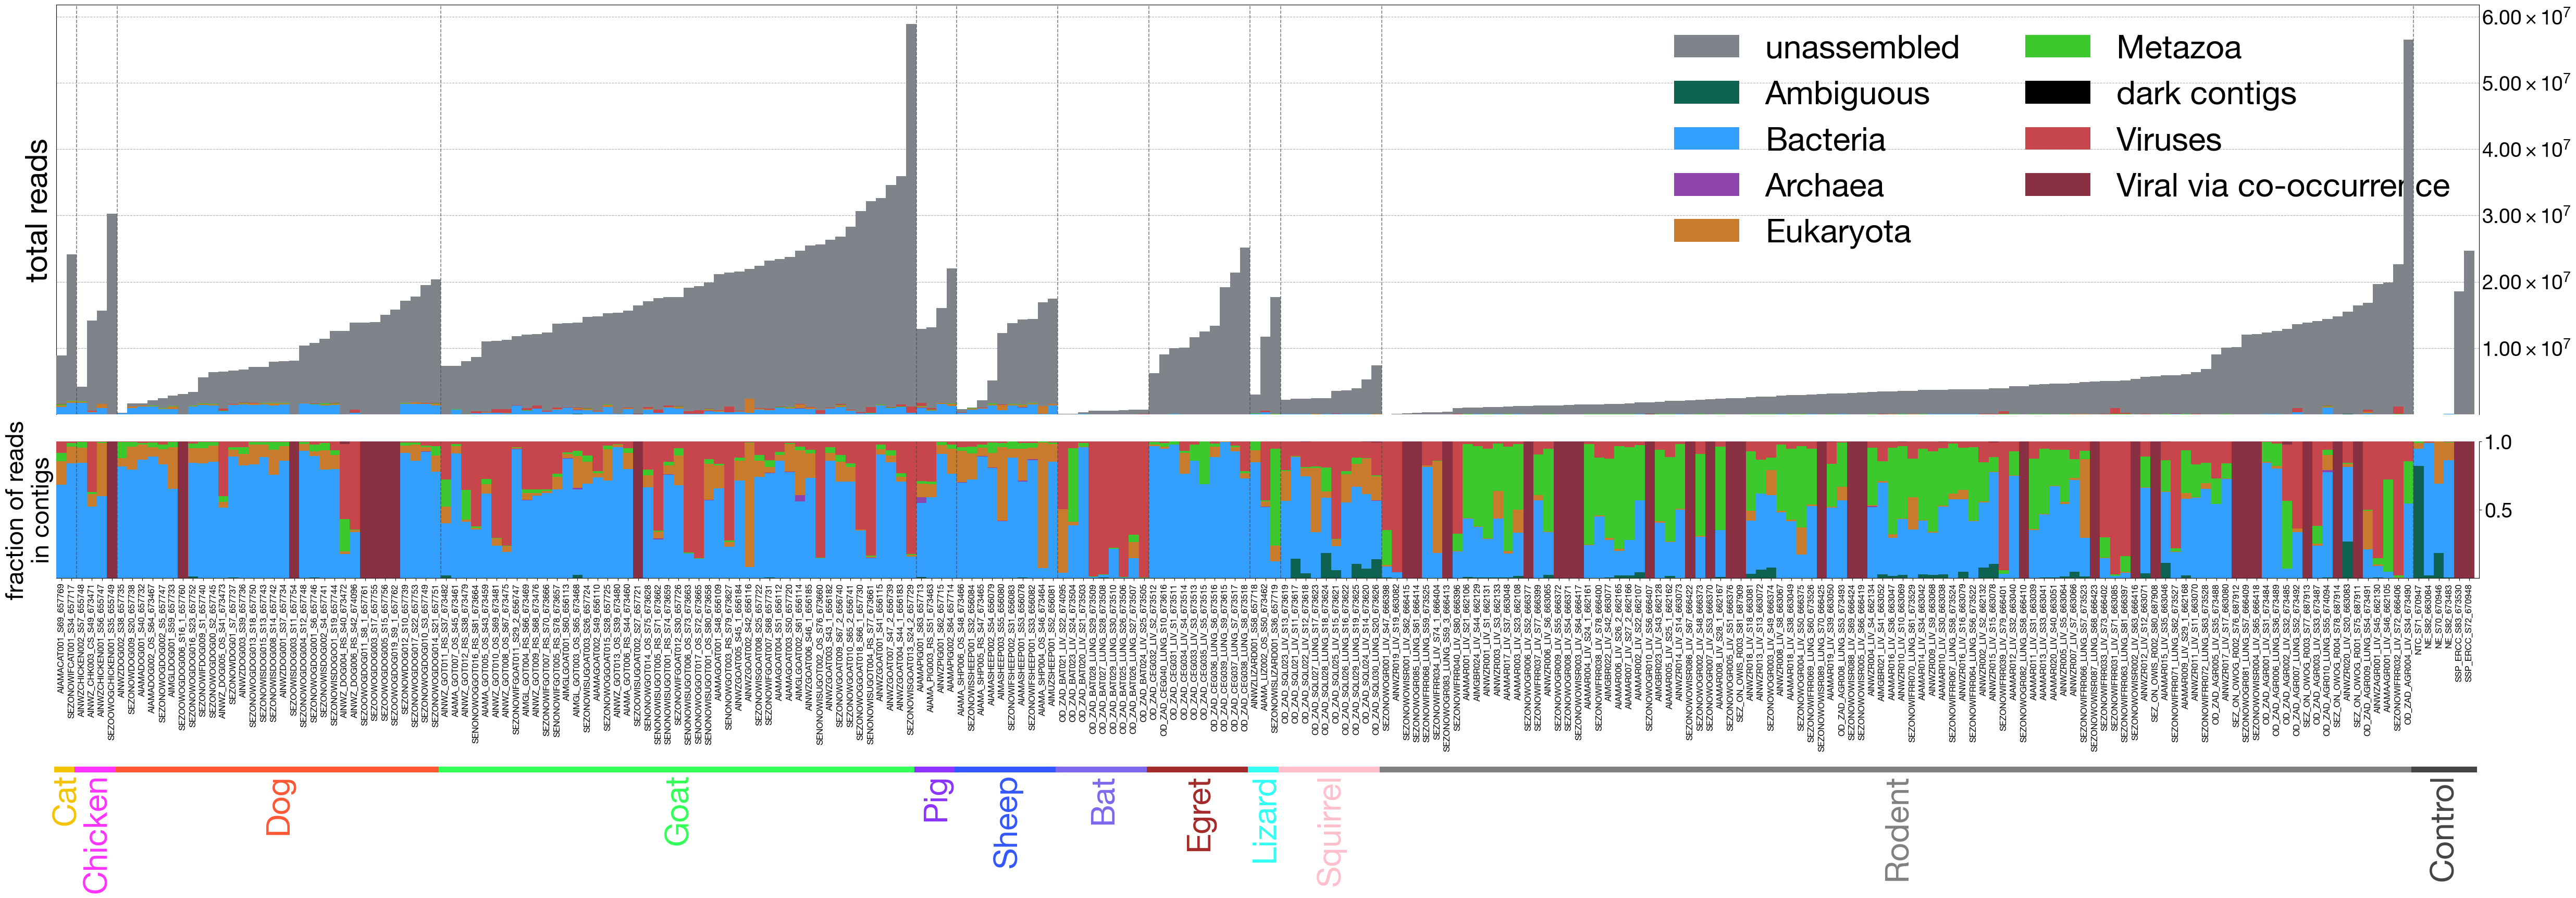

In [40]:
from collections import OrderedDict

# --- helpers ---
def size(k): return k['read_count']
def host_of(sample):
    return (metadata.get(sample, {}).get('ska_species', '') or
            metadata.get(sample, {}).get('ska_genus', '') or
            'Control').strip()

def extract_nested_reads(node, flat=None, order=None):
    if flat is None: flat = {}
    if order is None: order = 0
    flat[node['name']] = {'read_count': node['read_count'], 'colour': node['colour'], 'order': order}
    order += 1
    if 'children' in node:
        flat[node['name']]['children'] = []
        for child in sorted(node['children'], key=lambda k: -size(k)):
            flat, order = extract_nested_reads(child, flat, order)
            flat[node['name']]['children'].append(child['name'])
    return flat, order

# --- sort: group by host species, then by total reads ---
def sample_reads(s):
    return sum([contig_classification.get(s, {}).get(c, {}).get('read_count', 0)
                for c in contig_classification.get(s, {})])

candidates = [s for s in grand_tree if 'water' not in s.lower() and sample_reads(s) > 0]

desired_order = ["Cat","Chicken","Dog","Goat","Pig","Sheep","Bat","Egret","Lizard","Squirrel","Rodent","Control"]
host_priority = {h:i for i,h in enumerate(desired_order)}

sorted_samples = sorted(
    candidates,
    key=lambda s: (host_priority.get(host_of(s), len(host_priority)),
                   grand_tree[s]['read_count'])
)

read_areas = [grand_tree[s]['read_count'] for s in sorted_samples]

# --- figure ---
fig = plt.figure(figsize=(60,20), facecolor='w')
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1], wspace=0.05, hspace=0.1)
ax  = plt.subplot(gs[0], facecolor='w')
ax2 = plt.subplot(gs[1], facecolor='w')

M = max(read_areas) if len(read_areas) else 1.0
contig_categories = ['Ambiguous','Bacteria','Archaea','Eukaryota','Metazoa','dark contigs','Viruses','Viral via co-occurrence']

for s, sample in enumerate(sorted_samples):
    sample_tree   = grand_tree[sample]
    sample_total  = grand_tree[sample]['read_count']
    reads, _      = extract_nested_reads(sample_tree)

    # remove child counts from category totals for stacked plotting
    for g, group in enumerate(contig_categories):
        if 'children' in reads.get(group, {}):
            for ch in reads[group]['children']:
                reads[group]['read_count'] -= reads[ch]['read_count']

    cy = reads['contigs']['read_count']
    uy = reads['unassembled']['read_count']

    w = 1.0
    label = 'unassembled' if 'unassembled' not in ax.get_legend_handles_labels()[1] else ''
    ax.bar(s, uy, width=w, bottom=cy, facecolor=reads['unassembled']['colour'], zorder=100, label=label)

    contig_total = (sample_total - reads['unassembled']['read_count'])
    for g, group in enumerate(contig_categories):
        y = reads[group]['read_count']
        bottom = sum([reads[cc]['read_count'] for cc in contig_categories[:g]])
        fc = reads[group]['colour']
        label = group if group not in ax.get_legend_handles_labels()[1] else ''
        ax.bar(s, y, bottom=bottom, width=w, facecolor=fc, zorder=100, label=label)
        ax2.bar(s,
                (y/contig_total) if contig_total > 0 else 0,
                bottom=(bottom/contig_total) if contig_total > 0 else 0,
                width=w, facecolor=fc, zorder=100)

# --- no host labels on the top plot ---

# top panel cosmetics
ax.grid(axis='y', ls='--', zorder=0)
ax.yaxis.tick_right()
ax.tick_params(axis='y', size=0, labelsize=28)
ax.tick_params(axis='x', size=0, labelsize=0)
ax.set_ylabel('total reads', size=42)
fmt = lambda y, pos: '0.0' if (y==0.0 or y==np.nan) else r'$%.2f\times10^{%d}$'%(y*(10**-int(np.log10(y))), int(np.log10(y)))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))

# --- vertical lines between animal groups on BOTH panels ---
hosts = [host_of(s) for s in sorted_samples]
boundaries = [i + 0.5 for i in range(len(hosts) - 1) if hosts[i] != hosts[i+1]]

for x in boundaries:
    ax.axvline(x, ls='--', lw=1.2, color='0.3', alpha=0.7, zorder=150)
    ax2.axvline(x, ls='--', lw=1.2, color='0.3', alpha=0.7, zorder=150)

# bottom panel cosmetics
ax2.yaxis.tick_right()
ax2.tick_params(axis='y', labelsize=28)
ax2.set_ylabel('fraction of reads\nin contigs', size=34)
ax.set_xticklabels([])
ax2.set_xticks(range(len(sorted_samples)))
ax2.set_xticklabels(sorted_samples, rotation=90, size=12)
# Colors and name mapping
host_colour = {
    "Chicken": "#FF33FF", "Bat": "#7B68EE", "Dog": "#FF5733", "Goat": "#33FF57",
    "Egret": "#A52A2A",   "Cat": "#F4C300", "Sheep": "#3357FF", "Rodent": "grey",
    "Lizard": "#33FFF5",  "Squirrel": "#FFC0CB", "Pig": "#8C33FF", "Control": "#444444"
}

# --- single span line + one host name per group (beneath axis) ---
# --- single span line + one host name per group (beneath axis), colored by host ---
groups = OrderedDict()
for i, sname in enumerate(sorted_samples):
    groups.setdefault(host_of(sname), []).append(i)

plt.gcf().subplots_adjust(bottom=0.33)   # room for colored spans + labels
y_line = -1.4                           # axis-fraction below x-axis (make more -ve for more space)

for g, idxs in groups.items():
    start, end = min(idxs), max(idxs)
    x0 = start - 0.45
    x1 = end   + 0.45
    if start == end:
        x0, x1 = start - 0.45, start + 0.45

    c = host_colour.get(g, "#666666")    # fallback color if missing

    # colored span line
    ax2.plot([x0, x1], [y_line, y_line],
             lw=8, color=c, transform=ax2.get_xaxis_transform(), clip_on=False)

    # centered, color-matched group name
    ax2.text((x0 + x1) / 2, y_line - 0.035, g,
             ha='center', va='top', fontsize=45, rotation=90,
             color=c, transform=ax2.get_xaxis_transform(), clip_on=False)


ax.legend(loc='upper right', fontsize=45, ncol=2, frameon=False)
[ax.spines[loc].set_visible(False) for loc in ['bottom']]
[ax2.spines[loc].set_visible(False) for loc in ['top']]
ax.set_xlim(-0.5, len(sorted_samples))
ax2.set_xlim(ax.get_xlim())

plt.show()

In [41]:

# --------------------
# Config / aesthetics
# --------------------
typeface = 'Helvetica Neue'
mpl.rcParams['font.family'] = typeface
mpl.rcParams['font.size']   = 35

# Paths
meta_path   = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Metada_annotated.csv'
nga_geojson = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/gadm41_NGA_1.json'
out_base    = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Fig1_Sequencing_Sampling'

# Location labels/colors
rename        = {'Ondo': 'Ondo State', 'Ebonyi': 'Ebonyi State'}
sample_colour = {'Ondo': 'red', 'Ebonyi': 'Steelblue'}

# Host color maps (genus + species key for consistent hues)
genera_colours = {
    'Avian':'#FF33FF','Bat':'#7B68EE','Canine':'#FF5733','Caprine':'#33FF57','Cattle':'#A52A2A',
    'Feline':'#F4C300','Ovine':'#3357FF','Rat':'grey','Saurian':'#33FFF5','Squirrel':'#FFC0CB','Swine':'#8C33FF'
}
species_colours = {
    'Avian Chicken':'#FF33A6','Bat Bat':'#7B68EE','Canine Dog':'#4D7D73','Caprine Goat':'#884936',
    'Cattle Egret':'#A52A2A','Feline Cat':'#FFD433','Ovine Sheep':'#338CFF','Rat Rodent':'grey',
    'Saurian Lizard':'#33FFD4','Squirrel Squirrel':'#FFC0CB','Swine Pig':'#B833FF'
}

# Host display order & sample-type palette
host_order = ["Chicken","Bat","Dog","Goat","Egret","Cat","Sheep","Rodent","Lizard","Squirrel","Pig"]
sample_type_colours = {
    "Liver":"#e41a1c","Lung":"#377eb8","Spleen":"#4daf4a",
    "Oral swab":"#984ea3","Rectal/cloacal swab":"#ff7f00","Other":"#999999"
}
sample_type_order = ["Liver","Lung","Spleen","Oral swab","Rectal/cloacal swab","Other"]


# --------------------
# Load metadata
# --------------------
df = pd.read_csv(meta_path)

# Normalize columns
df["location"]       = df["collected_by"].astype(str).str.strip()
df["location_label"] = df["location"].map(rename).fillna(df["location"])
df["genus_species"]  = (df["ska_genus"].astype(str).str.strip() + " " +
                        df["ska_species"].astype(str).str.strip())

# Common host names for panels using a stable mapping
genus_to_common = {
    "Avian":"Chicken","Bat":"Bat","Canine":"Dog","Caprine":"Goat","Cattle":"Egret",
    "Feline":"Cat","Ovine":"Sheep","Rat":"Rodent","Saurian":"Lizard",
    "Squirrel":"Squirrel","Swine":"Pig"
}
df["host_common"] = df["ska_genus"].map(genus_to_common).fillna(df["ska_genus"].str.title())

# Sample-type normalization
def norm_sample_type(x: str) -> str:
    x = (str(x) or "").strip().lower()
    if x in {"liv","liver"}: return "Liver"
    if x in {"lun","lung"}: return "Lung"
    if x in {"spl","spleen"}: return "Spleen"
    if "oral" in x: return "Oral swab"
    if "rect" in x or "cloac" in x: return "Rectal/cloacal swab"
    return x.title() if x else "Other"
df["sample_type_norm"] = df["sample_type"].apply(norm_sample_type)



In [42]:
# --------------------
# Nigeria basemap bits (robust, no filtering)
# --------------------
geo_df = gpd.read_file(nga_geojson).to_crs("EPSG:4326")
locName = 'NAME_1'  # verify with: print(geo_df.columns)

polygons   = {}
loc_points = {}

def norm(s): 
    return str(s).strip().lower()

# Map various ways the state might appear -> short key
alias_to_short = {
    'ondo': 'Ondo',
    'ondo state': 'Ondo',
    'ebonyi': 'Ebonyi',
    'ebonyi state': 'Ebonyi',
}

for _, row in geo_df.iterrows():
    state = row[locName]
    geom  = row.geometry

    # collect polygons for ALL states so the outline always draws
    if geom.geom_type == "MultiPolygon":
        polys = list(geom.geoms)
    elif geom.geom_type == "Polygon":
        polys = [geom]
    else:
        polys = []

    polygons[state] = polys

    # capture representative points for our two states (robust matching)
    short = alias_to_short.get(norm(state))
    if short and short not in loc_points:
        rp = geom.representative_point()  # safer than centroid for multipolygons
        loc_points[short] = (float(rp.x), float(rp.y))

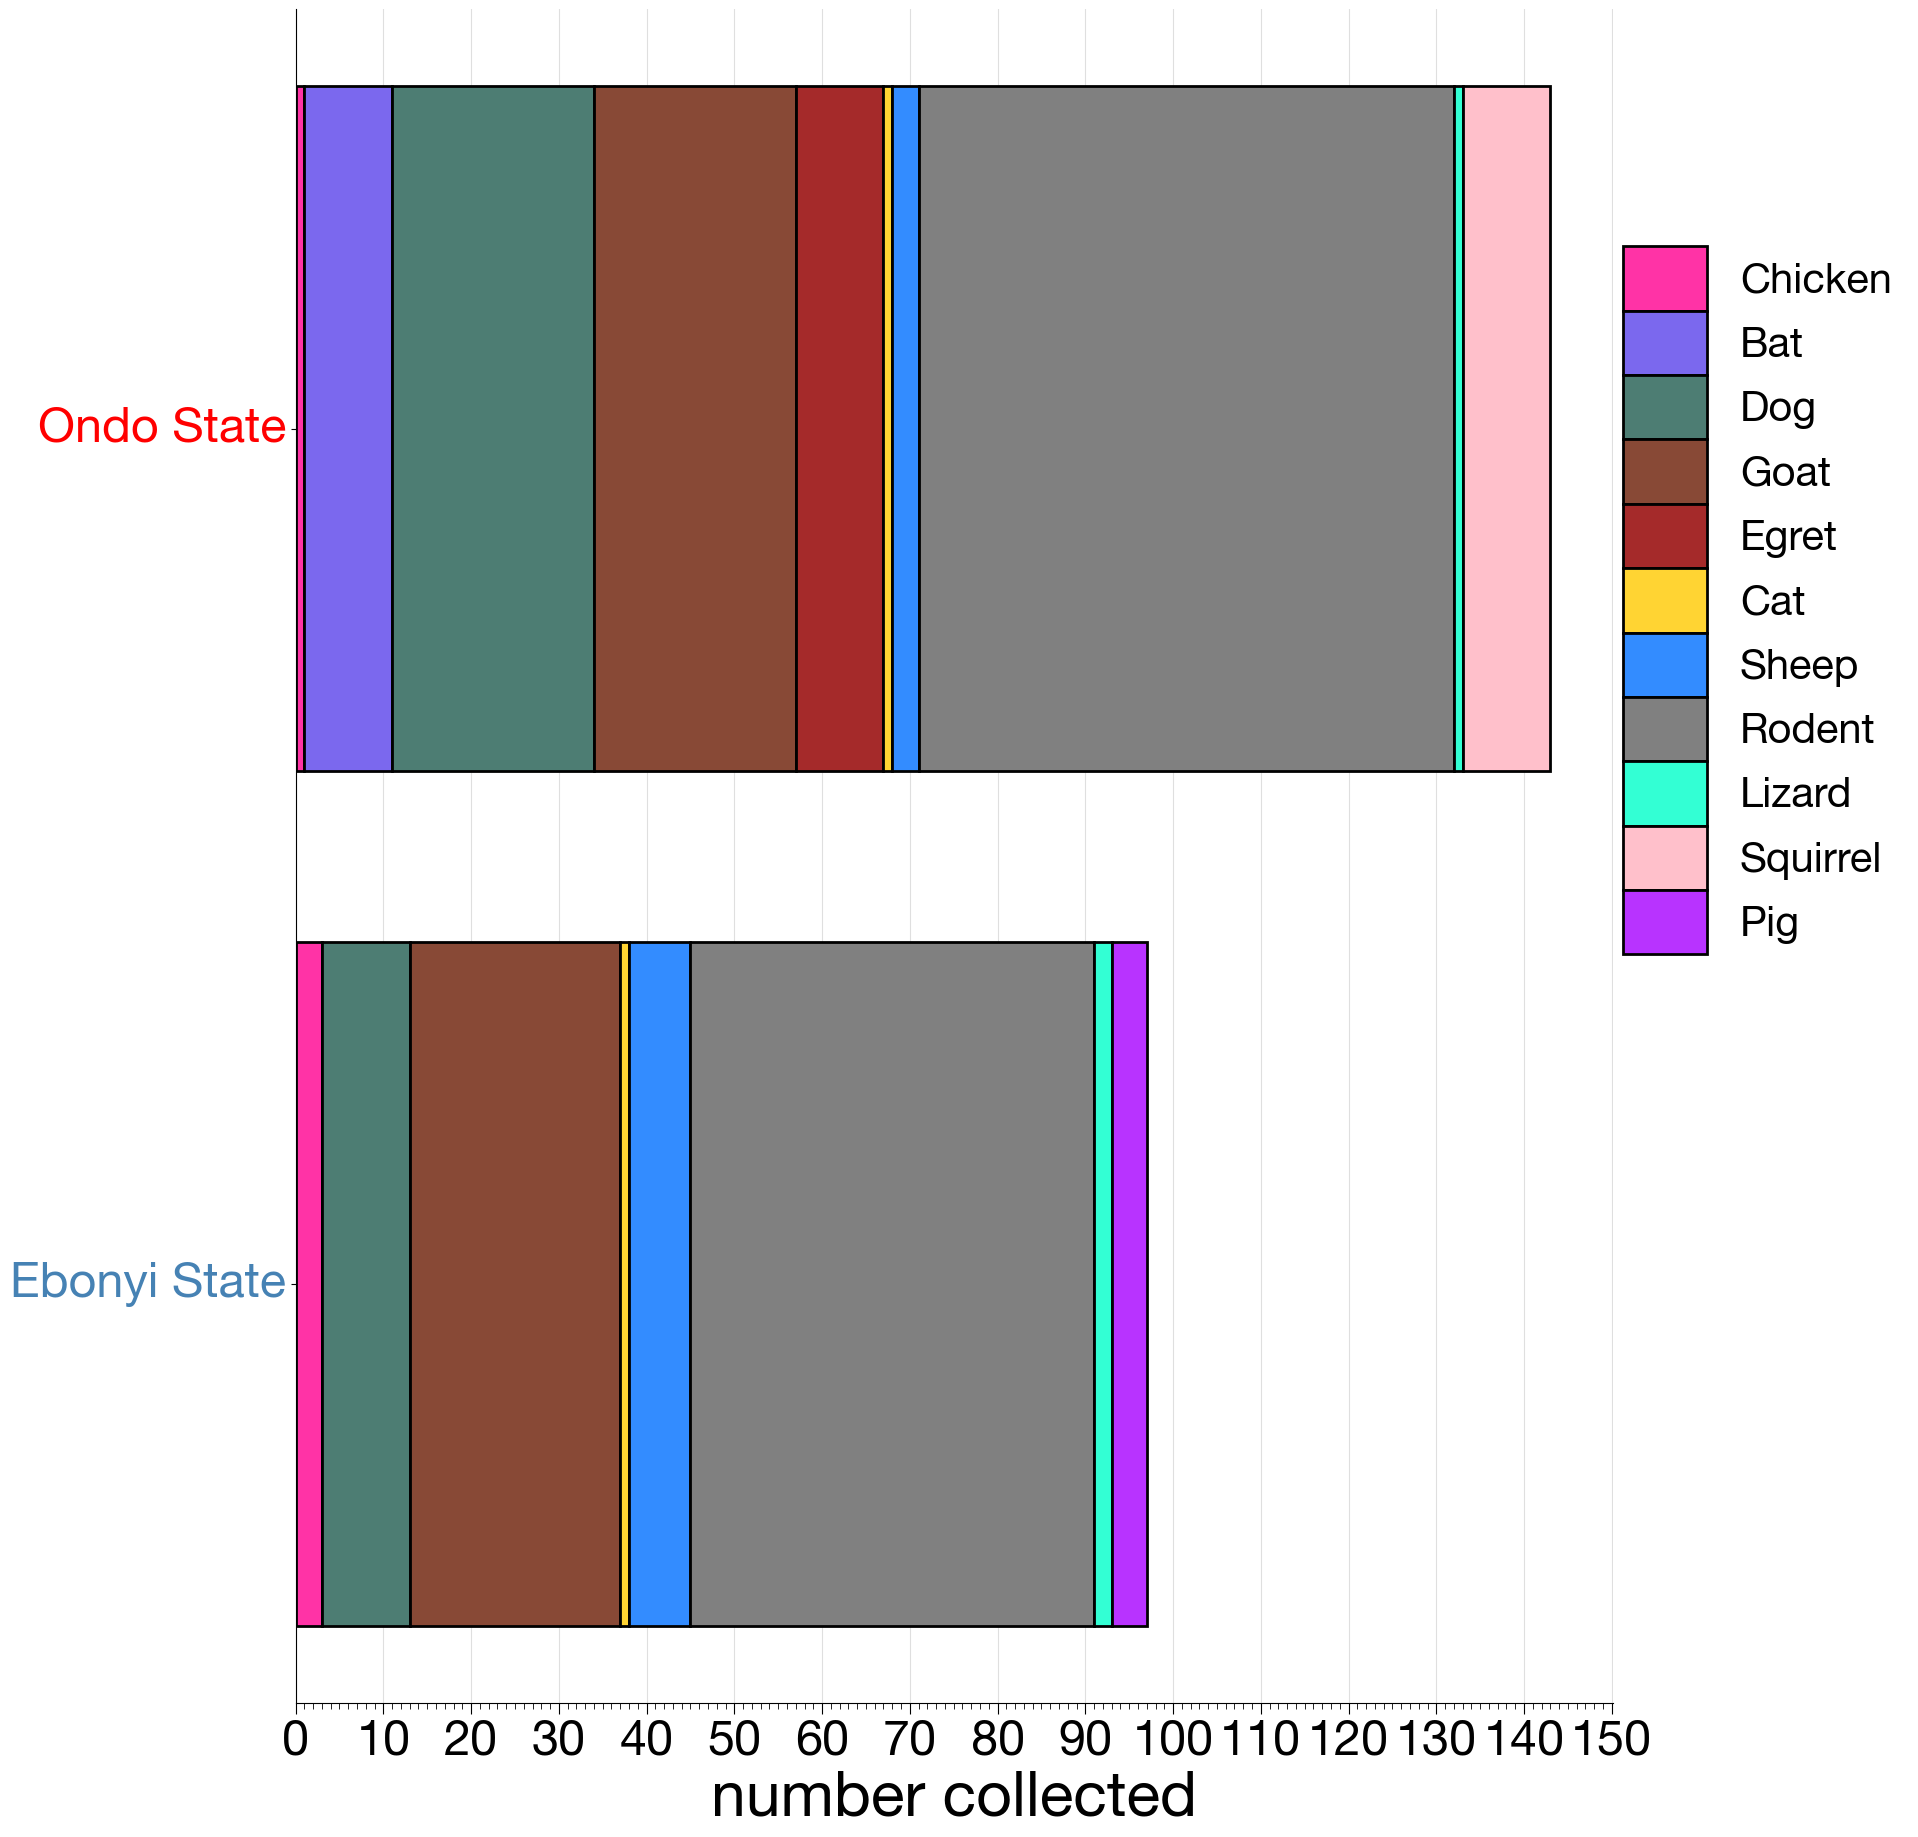

In [43]:
# --------------------
# Precompute counts
# --------------------
# Panel A: stacked horizontal bars by state (species within genus)
gs_counts = (df.groupby(["location_label","genus_species"])
               .size().reset_index(name="n"))

# Sample-type panel
st_counts = (df.groupby(["location_label","ska_genus","sample_type_norm"])
               .size().reset_index(name="n"))

# Host × State heatmap (raw counts)
host_counts = (df.groupby(["location_label","host_common"])
                 .size()
                 .unstack(fill_value=0))

# --------------------
# Figure canvas
# --------------------
fig = plt.figure(figsize=(17,22), facecolor='w')

# Panel A: stacked horizontal bars by state
ax = fig.add_subplot(1,1,1, facecolor='w')

loc_labels = [rename.get("Ebonyi","Ebonyi State"), rename.get("Ondo","Ondo State")]
loc_labels = [l for l in loc_labels if l in gs_counts["location_label"].unique()]

# de-dup legend labels across both states
seen_species_labels = set()

for i, loclbl in enumerate(loc_labels):
    sub = gs_counts[gs_counts["location_label"] == loclbl]
    # order species by our color dict key order, then any extras by count
    keys_in_sub = [k for k in species_colours.keys() if k in sub["genus_species"].unique()]
    extra = [k for k in sub["genus_species"].unique() if k not in keys_in_sub]
    # sort extras by count descending for stability
    extra = sorted(extra, key=lambda k: int(sub.loc[sub["genus_species"]==k, "n"].sum()), reverse=True)
    order = keys_in_sub + extra

    left = 0
    for key in order:
        n = int(sub.loc[sub["genus_species"]==key, "n"].sum())
        if n == 0:
            continue
        genus  = key.split()[0]
        sp_lab = key.split()[-1].title()  # legend name
        face   = species_colours.get(key, genera_colours.get(genus, "#999999"))

        label = sp_lab if sp_lab not in seen_species_labels else ""
        ax.barh(i, n, left=left, facecolor=face, edgecolor='k', lw=2,
                label=label, zorder=100)
        if label:
            seen_species_labels.add(sp_lab)
        left += n

# y ticks and colors
ax.set_yticks(range(len(loc_labels)))
ax.set_yticklabels(loc_labels, size=35, weight=500, va='center', ha='right')
# color ticks by state color
for tick in ax.get_yticklabels():
    short = [k for k,v in rename.items() if v == tick.get_text()]
    if short:
        tick.set_color(sample_colour.get(short[0], 'k'))

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
[ax.spines[s].set_visible(False) for s in ax.spines if s not in ['bottom','left']]
ax.grid(axis='x', alpha=0.4)
ax.set_xlabel('number collected', size=45)
ax.tick_params(axis='x', which='major', size=8, labelsize=35)
ax.tick_params(axis='x', which='minor', size=4, labelsize=0)

# Legend (sorted by genus then species)
def species_to_genus(sp_name):
    for k in species_colours:
        if sp_name == k.split()[-1].title():
            return k.split()[0]
    return "ZZZ"
boxes, labels = ax.get_legend_handles_labels()
if boxes:
    boxes, labels = zip(*sorted(zip(boxes,labels), key=lambda t: (species_to_genus(t[1]), t[1])))
    ax.legend(boxes, labels, loc=4, ncol=1, bbox_to_anchor=(1.24,0.42),
              fontsize=30, handlelength=2, handleheight=2, labelspacing=0.0, frameon=False)

In [44]:
# --------------------
# MAP panel (scaled circles + autoscale)
# --------------------
subax = fig.add_axes([0.62, 0.07, 0.49, 0.47], frame_on=False)
subax.set_aspect(1)
subax.tick_params(size=0, labelsize=0)
[subax.spines[s].set_visible(False) for s in subax.spines]

# draw ALL state polygons as background
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon as MplPolygon
for state, polys in polygons.items():
    mpl_polys = [MplPolygon(np.array(p.exterior.coords), closed=True) for p in polys]
    if mpl_polys:
        subax.add_collection(PatchCollection(mpl_polys, facecolor='w', edgecolor='k', zorder=0))

# autoscale to Nigeria bounds
minx, miny, maxx, maxy = geo_df.total_bounds
subax.set_xlim(minx, maxx)
subax.set_ylim(miny, maxy)

# circle sizes scaled by totals per state
totals_by_label = df.groupby("location_label").size()
min_s, max_s = 300, 2200
vmin = int(totals_by_label.min()) if len(totals_by_label) else 0
vmax = int(totals_by_label.max()) if len(totals_by_label) else 1
def size_for(n):
    if vmin == vmax: 
        return (min_s + max_s) / 2.0
    return np.interp(n, [vmin, vmax], [min_s, max_s])

for short in ("Ondo","Ebonyi"):
    if short in loc_points:
        lon, lat = loc_points[short]
        full = rename.get(short, short)  # 'Ondo State' / 'Ebonyi State'
        n    = int(totals_by_label.get(full, 0))
        s    = size_for(n)
        subax.scatter(lon, lat, s=s, facecolor=sample_colour[short],
                      edgecolor='k', linewidth=2.5, zorder=10)
        subax.text(lon, lat, f"{n}", ha='center', va='center',
                   fontsize=35, color='black', weight='bold', zorder=11)

In [45]:
# --------------------
# Panel: sample types per host × state (stacked bars)
# --------------------
ax_types = fig.add_axes([0.11, -0.28, 1.04, 0.28], facecolor='w')  # left, bottom, width, height
locs = [rename.get("Ondo","Ondo State"), rename.get("Ebonyi","Ebonyi State")]
locs = [l for l in locs if l in st_counts["location_label"].unique()]
bar_width, gap = 0.38, 0.10

# hosts present in data, ordered by host_order
hosts_present = df["host_common"].unique().tolist()
x_hosts = [h for h in host_order if h in hosts_present]
x_pos   = np.arange(len(x_hosts))

# order sample-type layers present in the data
layers = [s for s in sample_type_order if s in df["sample_type_norm"].unique()]

for i, loclbl in enumerate(locs):
    sub = st_counts[st_counts["location_label"] == loclbl].copy()
    sub["host_common"] = sub["ska_genus"].map(genus_to_common).fillna(sub["ska_genus"])
    bottoms = np.zeros(len(x_hosts))
    offset  = (i - (len(locs)-1)/2) * (bar_width + gap)
    for st in layers:
        y = np.array([sub.loc[(sub["host_common"]==h) &
                              (sub["sample_type_norm"]==st), "n"].sum() for h in x_hosts])
        ax_types.bar(x_pos + offset, y, width=bar_width, bottom=bottoms,
                     edgecolor='k', linewidth=1.5,
                     label=st if (i==0) else "",
                     color=sample_type_colours.get(st, "#999999"))
        bottoms += y

ax_types.set_xticks(x_pos)
ax_types.set_xticklabels(x_hosts, rotation=0, ha='center', fontsize=35)
ax_types.set_ylabel("samples", fontsize=45)
ax_types.set_ylim(0, max(1, ax_types.get_ylim()[1]))
[ax_types.spines[s].set_visible(False) for s in ["top","right"]]
ax_types.grid(axis="y", linestyle=":", alpha=0.4)
ax_types.legend(title="Sample type", ncol=2, fontsize=30, title_fontsize=35,
                frameon=False, bbox_to_anchor=(0.6, 1.1), loc="upper right")

In [46]:
# --- Hosts phylogeny + tip-wise sampling bars (right-side panel, no host labels on bars) ---
import re
import baltic as bt

# Inputs
orig_newick  = "/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Correct_newick_Hosts.tree"
clean_newick = "/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Hosts_tree_cleaned.nwk"

# Clean internal node labels like [100]
with open(orig_newick, "r") as fh:
    nwk = fh.read()
nwk_clean = re.sub(r"\[\d+\]", "", nwk)
with open(clean_newick, "w") as fh:
    fh.write(nwk_clean)

# Load tree
tree = bt.loadNewick(clean_newick, absoluteTime=False)
tree.treeStats()  # prints: numbers of objects, height, etc.
print("Tree height (root-to-tip):", tree.treeHeight)

# Colors and name mapping
host_colour = {
    "Chicken": "#FF33FF", "Bat": "#7B68EE", "Dog": "#FF5733", "Goat": "#33FF57",
    "Egret": "#A52A2A",   "Cat": "#F4C300", "Sheep": "#3357FF", "Rodent": "grey",
    "Lizard": "#33FFF5",  "Squirrel": "#FFC0CB", "Pig": "#8C33FF"
}
tip_alias = {
    "Avian":"Chicken","Canine":"Dog","Caprine":"Goat","Cattle":"Egret","Feline":"Cat",
    "Ovine":"Sheep","Rat":"Rodent","Saurian":"Lizard","Squirrel":"Squirrel","Swine":"Pig","Bat":"Bat",
    # pass-throughs
    "Chicken":"Chicken","Dog":"Dog","Goat":"Goat","Egret":"Egret","Cat":"Cat",
    "Sheep":"Sheep","Rodent":"Rodent","Lizard":"Lizard","Squirrel":"Squirrel","Pig":"Pig"
}
def map_tip(name:str)->str:
    return tip_alias.get(name, name)

pos_top = ax.get_position().y1
pos_bot = ax_types.get_position().y0    # bottom is the top of the bottom block
tree_lft, tree_w = 1.22, 0.43
ax_tree = fig.add_axes([tree_lft, pos_bot, tree_w, pos_top - pos_bot], facecolor='w')

# Draw tree
x_attr = lambda n: n.height
tree.plotTree(ax_tree, x_attr=x_attr)
tree.plotPoints(ax_tree, size=1000,
                colour=lambda n: host_colour.get(map_tip(n.name), "#C0C0C0"),
                x_attr=x_attr)

# Clean tree axes
for s in ["top","right","left","bottom"]:
    ax_tree.spines[s].set_visible(False)
ax_tree.set_xticks([])
ax_tree.set_yticks([])
# Give a touch of right padding based on actual height
ax_tree.set_xlim(0, tree.treeHeight * 1.06)

# Tip-aligned bar panel (shares y with tree); only numeric counts, no host names
bar_gap  = 0.003
bar_lft  = tree_lft + tree_w + bar_gap
bar_w    = 0.12
ax_tipbar = fig.add_axes([bar_lft, pos_bot, bar_w, pos_top - pos_bot],
                         facecolor='w', sharey=ax_tree)

# Build data: y positions from tree tips, counts per host from df
counts_by_host = df.groupby("host_common").size().to_dict()
tips = tree.getExternal()

ys    = [t.y for t in tips]
hosts = [map_tip(t.name) for t in tips]
vals  = [int(counts_by_host.get(h, 0)) for h in hosts]
cols  = [host_colour.get(h, "#C0C0C0") for h in hosts]

# Draw bars
bars = ax_tipbar.barh(ys, vals, height=0.6, color=cols, edgecolor='k', linewidth=1.0, zorder=10)

# Only counts at the end of each bar (no host labels)
max_val = max(vals) if vals else 1
ax_tipbar.set_xlim(0, max_val * 1.25)
pad = max_val * 0.02
for rect, v in zip(bars, vals):
    x = rect.get_width()
    y = rect.get_y() + rect.get_height()/2
    ax_tipbar.text(x + pad, y, f"{v}", va='center', ha='left', fontsize=35)

# Cosmetics
ax_tipbar.set_yticks(ys)
ax_tipbar.set_yticklabels("")      # no host names on the bars
ax_tipbar.set_xlabel("Number\nSampled", fontsize=35)
ax_tipbar.grid(axis="x", linestyle=":", alpha=0.4)
for s in ["top","right","left"]:
    ax_tipbar.spines[s].set_visible(False)


Tree height: 318.950000
Tree length: 1454.658080
strictly bifurcating tree
annotations present

Numbers of objects in tree: 21 (10 nodes and 11 leaves)

Tree height (root-to-tip): 318.95000000000005


In [47]:
# === Host-grouped read composition: full figure width BELOW sample-type panel ===
left_pad, right_pad = 0.05, -0.9
bottom_pad, gap_above = -0.75, 0.5

left_edge  = left_pad
width_fc   = 1.0 - left_pad - right_pad
top_limit  = ax_types.get_position().y0 - gap_above
total_h    = max(0.38, top_limit - bottom_pad)   # use ALL space below ax_types

# 3:1 split, like original
h_top = total_h * 0.75
h_bot = total_h * 0.25

ax_reads = fig.add_axes([left_edge, bottom_pad + h_bot, width_fc, h_top], facecolor='w')
ax_frac  = fig.add_axes([left_edge, bottom_pad,         width_fc, h_bot], facecolor='w', sharex=ax_reads)

# draw bars (unchanged logic)
read_areas = [grand_tree[s]['read_count'] for s in sorted_samples]
M = max(read_areas) if read_areas else 1.0

def _size(k): return k['read_count']
def _extract(node, flat=None, order=None):
    if flat is None: flat = {}
    if order is None: order = 0
    flat[node['name']] = {'read_count': node['read_count'], 'colour': node['colour'], 'order': order}
    order += 1
    if 'children' in node:
        flat[node['name']]['children'] = []
        for child in sorted(node['children'], key=lambda k: -_size(k)):
            flat, order = _extract(child, flat, order)
            flat[node['name']]['children'].append(child['name'])
    return flat, order

for i, sample in enumerate(sorted_samples):
    sample_tree  = grand_tree[sample]
    sample_total = grand_tree[sample]['read_count']
    reads, _     = _extract(sample_tree)

    for group in contig_categories:
        if 'children' in reads.get(group, {}):
            for ch in reads[group]['children']:
                reads[group]['read_count'] -= reads[ch]['read_count']

    cy = reads['contigs']['read_count']
    uy = reads['unassembled']['read_count']
    w  = 1.0

    if 'unassembled' not in ax_reads.get_legend_handles_labels()[1]:
        ax_reads.bar(i, uy, width=w, bottom=cy, facecolor=reads['unassembled']['colour'],
                     zorder=100, label='unassembled')
    else:
        ax_reads.bar(i, uy, width=w, bottom=cy, facecolor=reads['unassembled']['colour'], zorder=100)

    contig_total = max(1, sample_total - uy)
    bottom = 0
    for group in contig_categories:
        y, fc = reads[group]['read_count'], reads[group]['colour']
        if group not in ax_reads.get_legend_handles_labels()[1]:
            ax_reads.bar(i, y, bottom=bottom, width=w, facecolor=fc, zorder=100, label=group)
        else:
            ax_reads.bar(i, y, bottom=bottom, width=w, facecolor=fc, zorder=100)

        ax_frac.bar(i, y/contig_total, bottom=bottom/contig_total, width=w, facecolor=fc, zorder=100)
        bottom += y

# cosmetics & labels
fmt_reads = lambda y, pos: '0.0' if (y==0.0 or y==np.nan) else r'$%.2f\times10^{%d}$'%(y*(10**-int(np.log10(y))), int(np.log10(y)))
ax_reads.grid(axis='y', ls='--', zorder=0)
ax_reads.yaxis.tick_right()
ax_reads.tick_params(axis='y', size=0, labelsize=28)
ax_reads.tick_params(axis='x', size=0, labelsize=0)
ax_reads.set_ylabel('total reads', size=42)
ax_reads.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt_reads))

ax_frac.yaxis.tick_right()
ax_frac.tick_params(axis='y', labelsize=28)
ax_frac.set_ylabel('fraction of reads\nin contigs', size=34)
ax_reads.set_xticklabels([])
ax_frac.set_xticks(range(len(sorted_samples)))
ax_frac.set_xticklabels(sorted_samples, rotation=90, size=10)  # a touch smaller for readability

# group separators and colored spans
hosts = [host_of(s) for s in sorted_samples]
boundaries = [j + 0.5 for j in range(len(hosts)-1) if hosts[j] != hosts[j+1]]
for x in boundaries:
    ax_reads.axvline(x, ls='--', lw=1.2, color='0.3', alpha=0.7, zorder=150)
    ax_frac.axvline(x,  ls='--', lw=1.2, color='0.3', alpha=0.7, zorder=150)

from collections import OrderedDict as _OD
groups = _OD()
for i, sname in enumerate(sorted_samples):
    groups.setdefault(host_of(sname), []).append(i)

y_line = -1.55
for gname, idxs in groups.items():
    start, end = min(idxs), max(idxs)
    x0, x1 = start - 0.45, end + 0.45
    c = host_colour.get(gname, "#666666")
    ax_frac.plot([x0, x1], [y_line, y_line], lw=8, color=c,
                 transform=ax_frac.get_xaxis_transform(), clip_on=False)
    ax_frac.text((x0 + x1)/2, y_line - 0.05, gname,
                 ha='center', va='top', fontsize=45, rotation=90,
                 color=c, transform=ax_frac.get_xaxis_transform(), clip_on=False)

ax_reads.legend(loc='upper right', fontsize=28, ncol=2, frameon=False)
[ax_reads.spines[s].set_visible(False) for s in ['bottom']]
[ax_frac.spines[s].set_visible(False) for s in ['top']]
ax_reads.set_xlim(-0.5, len(sorted_samples))
ax_frac.set_xlim(ax_reads.get_xlim())


# === Panel labels ===
label_kws = dict(fontsize=50, fontweight='bold', ha='left', va='bottom')

# A: number of host collected (top-left stacked bars)
ax.text(-0.08, 1.04, 'A' , transform=ax.transAxes, **label_kws)

# B: Sample type (stacked bars panel)
ax_types.text(-0.08, 1.10, 'B', transform=ax_types.transAxes, **label_kws)

# C: Host phylogeny (tree on the right)
ax_tree.text(-0.12, 1.02, 'C', transform=ax_tree.transAxes, **label_kws)

# D: reads (bottom read composition)
ax_reads.text(-0.02, 1.02, 'D', transform=ax_reads.transAxes, **label_kws)




<Figure size 640x480 with 0 Axes>


Tree height: 318.950000
Tree length: 1454.658080
strictly bifurcating tree
annotations present

Numbers of objects in tree: 21 (10 nodes and 11 leaves)

Tree height (root-to-tip): 318.95000000000005


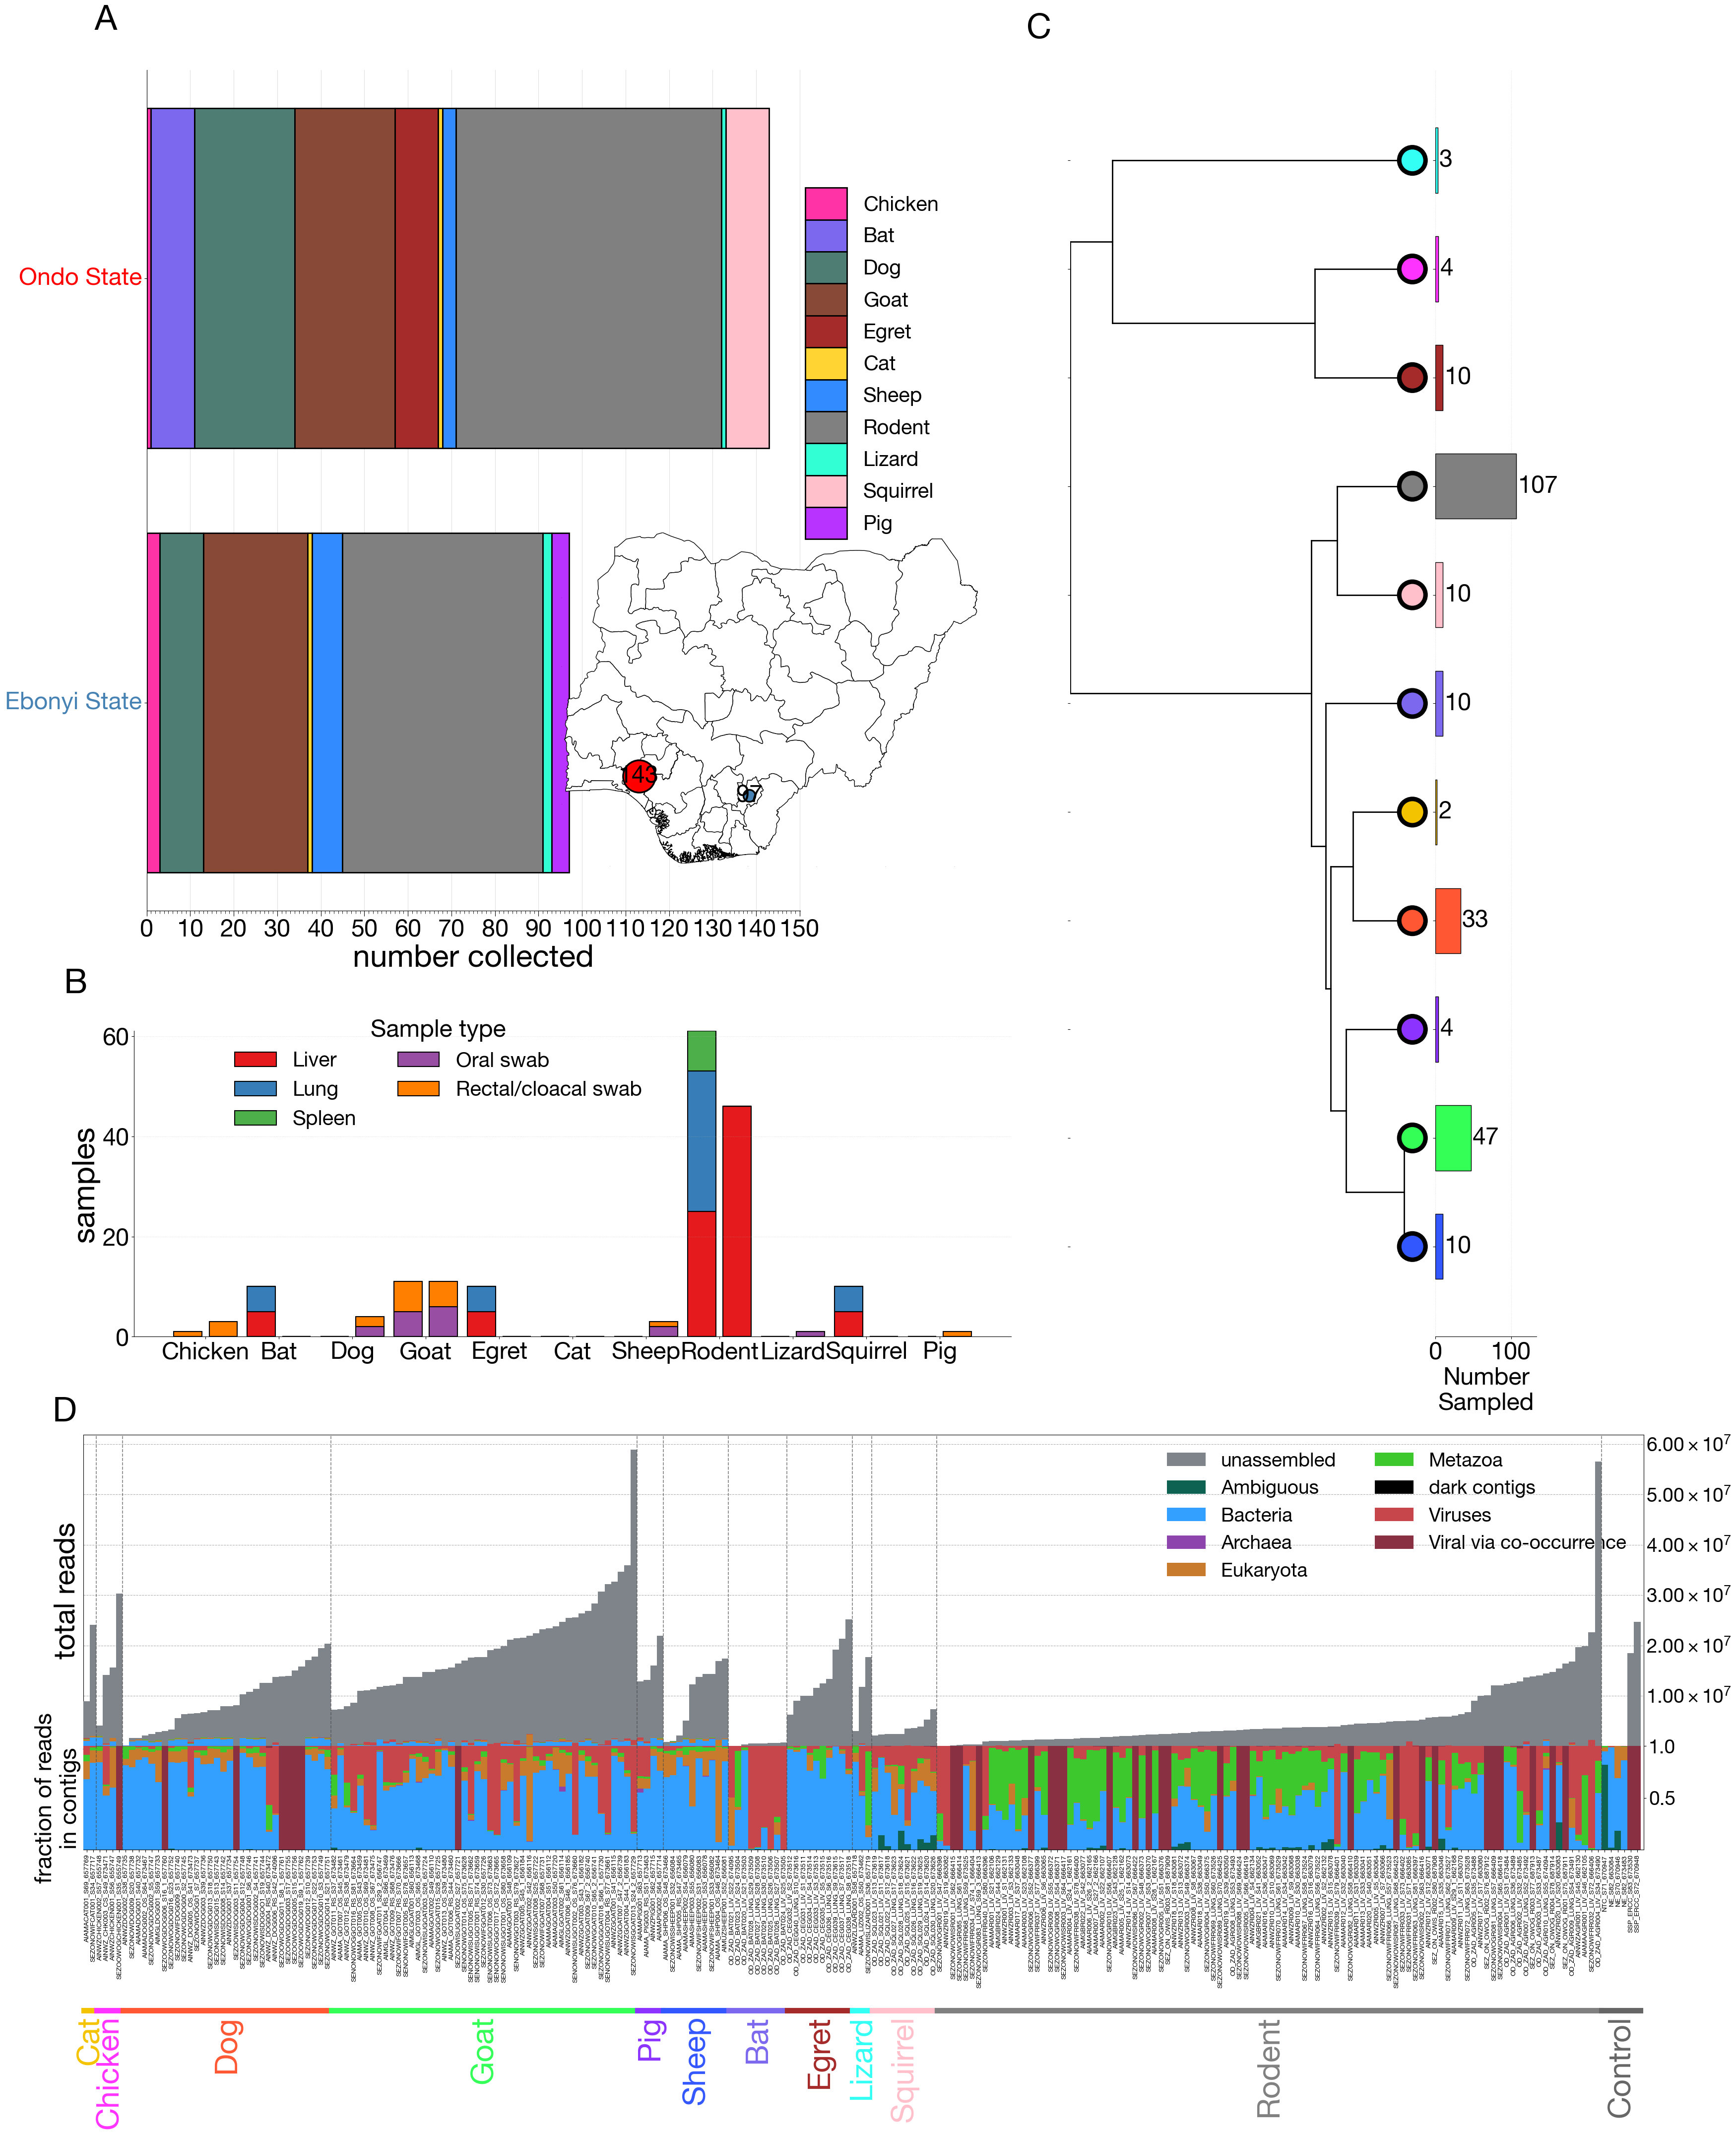

In [66]:
# --- Fig.1 (Sampling): host counts, sample types, and map with scaled circles ---





# Std libs & plotting
import os, csv, numpy as np, pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
import seaborn as sns
import geopandas as gpd

# --------------------
# Config / aesthetics
# --------------------
typeface = 'Helvetica Neue'
mpl.rcParams['font.family'] = typeface
mpl.rcParams['font.size']   = 35

# Paths
meta_path   = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Metada_annotated.csv'
nga_geojson = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/gadm41_NGA_1.json'
out_base    = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Fig1_Sequencing_Sampling'

# Location labels/colors
rename        = {'Ondo': 'Ondo State', 'Ebonyi': 'Ebonyi State'}
sample_colour = {'Ondo': 'red', 'Ebonyi': 'Steelblue'}

# Host color maps (genus + species key for consistent hues)
genera_colours = {
    'Avian':'#FF33FF','Bat':'#7B68EE','Canine':'#FF5733','Caprine':'#33FF57','Cattle':'#A52A2A',
    'Feline':'#F4C300','Ovine':'#3357FF','Rat':'grey','Saurian':'#33FFF5','Squirrel':'#FFC0CB','Swine':'#8C33FF'
}
species_colours = {
    'Avian Chicken':'#FF33A6','Bat Bat':'#7B68EE','Canine Dog':'#4D7D73','Caprine Goat':'#884936',
    'Cattle Egret':'#A52A2A','Feline Cat':'#FFD433','Ovine Sheep':'#338CFF','Rat Rodent':'grey',
    'Saurian Lizard':'#33FFD4','Squirrel Squirrel':'#FFC0CB','Swine Pig':'#B833FF'
}

# Host display order & sample-type palette
host_order = ["Chicken","Bat","Dog","Goat","Egret","Cat","Sheep","Rodent","Lizard","Squirrel","Pig"]
sample_type_colours = {
    "Liver":"#e41a1c","Lung":"#377eb8","Spleen":"#4daf4a",
    "Oral swab":"#984ea3","Rectal/cloacal swab":"#ff7f00","Other":"#999999"
}
sample_type_order = ["Liver","Lung","Spleen","Oral swab","Rectal/cloacal swab","Other"]

# --------------------
# Load metadata
# --------------------
df = pd.read_csv(meta_path)

# Normalize columns
df["location"]       = df["collected_by"].astype(str).str.strip()
df["location_label"] = df["location"].map(rename).fillna(df["location"])
df["genus_species"]  = (df["ska_genus"].astype(str).str.strip() + " " +
                        df["ska_species"].astype(str).str.strip())

# Common host names for panels using a stable mapping
genus_to_common = {
    "Avian":"Chicken","Bat":"Bat","Canine":"Dog","Caprine":"Goat","Cattle":"Egret",
    "Feline":"Cat","Ovine":"Sheep","Rat":"Rodent","Saurian":"Lizard",
    "Squirrel":"Squirrel","Swine":"Pig"
}
df["host_common"] = df["ska_genus"].map(genus_to_common).fillna(df["ska_genus"].str.title())

# Sample-type normalization
def norm_sample_type(x: str) -> str:
    x = (str(x) or "").strip().lower()
    if x in {"liv","liver"}: return "Liver"
    if x in {"lun","lung"}: return "Lung"
    if x in {"spl","spleen"}: return "Spleen"
    if "oral" in x: return "Oral swab"
    if "rect" in x or "cloac" in x: return "Rectal/cloacal swab"
    return x.title() if x else "Other"
df["sample_type_norm"] = df["sample_type"].apply(norm_sample_type)

# --------------------
# Nigeria basemap bits (robust, no filtering)
# --------------------
geo_df = gpd.read_file(nga_geojson).to_crs("EPSG:4326")
locName = 'NAME_1'  # verify with: print(geo_df.columns)

polygons   = {}
loc_points = {}

def norm(s): 
    return str(s).strip().lower()

# Map various ways the state might appear -> short key
alias_to_short = {
    'ondo': 'Ondo',
    'ondo state': 'Ondo',
    'ebonyi': 'Ebonyi',
    'ebonyi state': 'Ebonyi',
}

for _, row in geo_df.iterrows():
    state = row[locName]
    geom  = row.geometry

    # collect polygons for ALL states so the outline always draws
    if geom.geom_type == "MultiPolygon":
        polys = list(geom.geoms)
    elif geom.geom_type == "Polygon":
        polys = [geom]
    else:
        polys = []

    polygons[state] = polys

    # capture representative points for our two states (robust matching)
    short = alias_to_short.get(norm(state))
    if short and short not in loc_points:
        rp = geom.representative_point()  # safer than centroid for multipolygons
        loc_points[short] = (float(rp.x), float(rp.y))

# --------------------
# Precompute counts
# --------------------
# Panel A: stacked horizontal bars by state (species within genus)
gs_counts = (df.groupby(["location_label","genus_species"])
               .size().reset_index(name="n"))

# Sample-type panel
st_counts = (df.groupby(["location_label","ska_genus","sample_type_norm"])
               .size().reset_index(name="n"))

# Host × State heatmap (raw counts)
host_counts = (df.groupby(["location_label","host_common"])
                 .size()
                 .unstack(fill_value=0))

# --------------------
# Figure canvas
# --------------------
fig = plt.figure(figsize=(17,22), facecolor='w')

# Panel A: stacked horizontal bars by state
ax = fig.add_subplot(1,1,1, facecolor='w')

loc_labels = [rename.get("Ebonyi","Ebonyi State"), rename.get("Ondo","Ondo State")]
loc_labels = [l for l in loc_labels if l in gs_counts["location_label"].unique()]

# de-dup legend labels across both states
seen_species_labels = set()

for i, loclbl in enumerate(loc_labels):
    sub = gs_counts[gs_counts["location_label"] == loclbl]
    # order species by our color dict key order, then any extras by count
    keys_in_sub = [k for k in species_colours.keys() if k in sub["genus_species"].unique()]
    extra = [k for k in sub["genus_species"].unique() if k not in keys_in_sub]
    # sort extras by count descending for stability
    extra = sorted(extra, key=lambda k: int(sub.loc[sub["genus_species"]==k, "n"].sum()), reverse=True)
    order = keys_in_sub + extra

    left = 0
    for key in order:
        n = int(sub.loc[sub["genus_species"]==key, "n"].sum())
        if n == 0:
            continue
        genus  = key.split()[0]
        sp_lab = key.split()[-1].title()  # legend name
        face   = species_colours.get(key, genera_colours.get(genus, "#999999"))

        label = sp_lab if sp_lab not in seen_species_labels else ""
        ax.barh(i, n, left=left, facecolor=face, edgecolor='k', lw=2,
                label=label, zorder=100)
        if label:
            seen_species_labels.add(sp_lab)
        left += n

# y ticks and colors
ax.set_yticks(range(len(loc_labels)))
ax.set_yticklabels(loc_labels, size=35, weight=500, va='center', ha='right')
# color ticks by state color
for tick in ax.get_yticklabels():
    short = [k for k,v in rename.items() if v == tick.get_text()]
    if short:
        tick.set_color(sample_colour.get(short[0], 'k'))

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
[ax.spines[s].set_visible(False) for s in ax.spines if s not in ['bottom','left']]
ax.grid(axis='x', alpha=0.4)
ax.set_xlabel('number collected', size=45)
ax.tick_params(axis='x', which='major', size=8, labelsize=35)
ax.tick_params(axis='x', which='minor', size=4, labelsize=0)

# Legend (sorted by genus then species)
def species_to_genus(sp_name):
    for k in species_colours:
        if sp_name == k.split()[-1].title():
            return k.split()[0]
    return "ZZZ"
boxes, labels = ax.get_legend_handles_labels()
if boxes:
    boxes, labels = zip(*sorted(zip(boxes,labels), key=lambda t: (species_to_genus(t[1]), t[1])))
    ax.legend(boxes, labels, loc=4, ncol=1, bbox_to_anchor=(1.24,0.42),
              fontsize=30, handlelength=2, handleheight=2, labelspacing=0.0, frameon=False)

# --------------------
# MAP panel (scaled circles + fixed autoscale + clean legend)
# --------------------
# --------------------
# MAP panel (scaled circles + autoscale)
# --------------------
subax = fig.add_axes([0.62, 0.07, 0.49, 0.47], frame_on=False)
subax.set_aspect(1)
subax.tick_params(size=0, labelsize=0)
[subax.spines[s].set_visible(False) for s in subax.spines]

# draw ALL state polygons as background
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon as MplPolygon
for state, polys in polygons.items():
    mpl_polys = [MplPolygon(np.array(p.exterior.coords), closed=True) for p in polys]
    if mpl_polys:
        subax.add_collection(PatchCollection(mpl_polys, facecolor='w', edgecolor='k', zorder=0))

# autoscale to Nigeria bounds
minx, miny, maxx, maxy = geo_df.total_bounds
subax.set_xlim(minx, maxx)
subax.set_ylim(miny, maxy)

# circle sizes scaled by totals per state
totals_by_label = df.groupby("location_label").size()
min_s, max_s = 300, 2200
vmin = int(totals_by_label.min()) if len(totals_by_label) else 0
vmax = int(totals_by_label.max()) if len(totals_by_label) else 1
def size_for(n):
    if vmin == vmax: 
        return (min_s + max_s) / 2.0
    return np.interp(n, [vmin, vmax], [min_s, max_s])

for short in ("Ondo","Ebonyi"):
    if short in loc_points:
        lon, lat = loc_points[short]
        full = rename.get(short, short)  # 'Ondo State' / 'Ebonyi State'
        n    = int(totals_by_label.get(full, 0))
        s    = size_for(n)
        subax.scatter(lon, lat, s=s, facecolor=sample_colour[short],
                      edgecolor='k', linewidth=2.5, zorder=10)
        subax.text(lon, lat, f"{n}", ha='center', va='center',
                   fontsize=35, color='black', weight='bold', zorder=11)


# --------------------
# Panel: sample types per host × state (stacked bars)
# --------------------
ax_types = fig.add_axes([0.11, -0.28, 1.04, 0.28], facecolor='w')  # left, bottom, width, height
locs = [rename.get("Ondo","Ondo State"), rename.get("Ebonyi","Ebonyi State")]
locs = [l for l in locs if l in st_counts["location_label"].unique()]
bar_width, gap = 0.38, 0.10

# hosts present in data, ordered by host_order
hosts_present = df["host_common"].unique().tolist()
x_hosts = [h for h in host_order if h in hosts_present]
x_pos   = np.arange(len(x_hosts))

# order sample-type layers present in the data
layers = [s for s in sample_type_order if s in df["sample_type_norm"].unique()]

for i, loclbl in enumerate(locs):
    sub = st_counts[st_counts["location_label"] == loclbl].copy()
    sub["host_common"] = sub["ska_genus"].map(genus_to_common).fillna(sub["ska_genus"])
    bottoms = np.zeros(len(x_hosts))
    offset  = (i - (len(locs)-1)/2) * (bar_width + gap)
    for st in layers:
        y = np.array([sub.loc[(sub["host_common"]==h) &
                              (sub["sample_type_norm"]==st), "n"].sum() for h in x_hosts])
        ax_types.bar(x_pos + offset, y, width=bar_width, bottom=bottoms,
                     edgecolor='k', linewidth=1.5,
                     label=st if (i==0) else "",
                     color=sample_type_colours.get(st, "#999999"))
        bottoms += y

ax_types.set_xticks(x_pos)
ax_types.set_xticklabels(x_hosts, rotation=0, ha='center', fontsize=35)
ax_types.set_ylabel("samples", fontsize=45)
ax_types.set_ylim(0, max(1, ax_types.get_ylim()[1]))
[ax_types.spines[s].set_visible(False) for s in ["top","right"]]
ax_types.grid(axis="y", linestyle=":", alpha=0.4)
ax_types.legend(title="Sample type", ncol=2, fontsize=30, title_fontsize=35,
                frameon=False, bbox_to_anchor=(0.6, 1.1), loc="upper right")

# --- Hosts phylogeny + tip-wise sampling bars (right-side panel, no host labels on bars) ---
import re
import baltic as bt

# Inputs
orig_newick  = "/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Correct_newick_Hosts.tree"
clean_newick = "/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Hosts_tree_cleaned.nwk"

# Clean internal node labels like [100]
with open(orig_newick, "r") as fh:
    nwk = fh.read()
nwk_clean = re.sub(r"\[\d+\]", "", nwk)
with open(clean_newick, "w") as fh:
    fh.write(nwk_clean)

# Load tree
tree = bt.loadNewick(clean_newick, absoluteTime=False)
tree.treeStats()  # prints: numbers of objects, height, etc.
print("Tree height (root-to-tip):", tree.treeHeight)

# Colors and name mapping
host_colour = {
    "Chicken": "#FF33FF", "Bat": "#7B68EE", "Dog": "#FF5733", "Goat": "#33FF57",
    "Egret": "#A52A2A",   "Cat": "#F4C300", "Sheep": "#3357FF", "Rodent": "grey",
    "Lizard": "#33FFF5",  "Squirrel": "#FFC0CB", "Pig": "#8C33FF"
}
tip_alias = {
    "Avian":"Chicken","Canine":"Dog","Caprine":"Goat","Cattle":"Egret","Feline":"Cat",
    "Ovine":"Sheep","Rat":"Rodent","Saurian":"Lizard","Squirrel":"Squirrel","Swine":"Pig","Bat":"Bat",
    # pass-throughs
    "Chicken":"Chicken","Dog":"Dog","Goat":"Goat","Egret":"Egret","Cat":"Cat",
    "Sheep":"Sheep","Rodent":"Rodent","Lizard":"Lizard","Squirrel":"Squirrel","Pig":"Pig"
}
def map_tip(name:str)->str:
    return tip_alias.get(name, name)

pos_top = ax.get_position().y1
pos_bot = ax_types.get_position().y0    # bottom is the top of the bottom block
tree_lft, tree_w = 1.22, 0.43
ax_tree = fig.add_axes([tree_lft, pos_bot, tree_w, pos_top - pos_bot], facecolor='w')

# Draw tree
x_attr = lambda n: n.height
tree.plotTree(ax_tree, x_attr=x_attr)
tree.plotPoints(ax_tree, size=1000,
                colour=lambda n: host_colour.get(map_tip(n.name), "#C0C0C0"),
                x_attr=x_attr)

# Clean tree axes
for s in ["top","right","left","bottom"]:
    ax_tree.spines[s].set_visible(False)
ax_tree.set_xticks([])
ax_tree.set_yticks([])
# Give a touch of right padding based on actual height
ax_tree.set_xlim(0, tree.treeHeight * 1.06)

# Tip-aligned bar panel (shares y with tree); only numeric counts, no host names
bar_gap  = 0.003
bar_lft  = tree_lft + tree_w + bar_gap
bar_w    = 0.12
ax_tipbar = fig.add_axes([bar_lft, pos_bot, bar_w, pos_top - pos_bot],
                         facecolor='w', sharey=ax_tree)

# Build data: y positions from tree tips, counts per host from df
counts_by_host = df.groupby("host_common").size().to_dict()
tips = tree.getExternal()

ys    = [t.y for t in tips]
hosts = [map_tip(t.name) for t in tips]
vals  = [int(counts_by_host.get(h, 0)) for h in hosts]
cols  = [host_colour.get(h, "#C0C0C0") for h in hosts]

# Draw bars
bars = ax_tipbar.barh(ys, vals, height=0.6, color=cols, edgecolor='k', linewidth=1.0, zorder=10)

# Only counts at the end of each bar (no host labels)
max_val = max(vals) if vals else 1
ax_tipbar.set_xlim(0, max_val * 1.25)
pad = max_val * 0.02
for rect, v in zip(bars, vals):
    x = rect.get_width()
    y = rect.get_y() + rect.get_height()/2
    ax_tipbar.text(x + pad, y, f"{v}", va='center', ha='left', fontsize=35)

# Cosmetics
ax_tipbar.set_yticks(ys)
ax_tipbar.set_yticklabels("")      # no host names on the bars
ax_tipbar.set_xlabel("Number\nSampled", fontsize=35)
ax_tipbar.grid(axis="x", linestyle=":", alpha=0.4)
for s in ["top","right","left"]:
    ax_tipbar.spines[s].set_visible(False)


# === Add original-sized host-grouped read composition subplot spanning below the top panel ===
# expects: sorted_samples, grand_tree, contig_categories, host_of, host_colour

# === Add original-sized host-grouped read composition subplot spanning left column under top panel ===
# expects: sorted_samples, grand_tree, contig_categories, host_of, host_colour

# === Host-grouped read composition: full-width block BELOW sample-type panel ===
# expects: sorted_samples, grand_tree, contig_categories, host_of, host_colour

# === Host-grouped read composition: full figure width BELOW sample-type panel ===
left_pad, right_pad = 0.05, -0.9
bottom_pad, gap_above = -0.75, 0.5

left_edge  = left_pad
width_fc   = 1.0 - left_pad - right_pad
top_limit  = ax_types.get_position().y0 - gap_above
total_h    = max(0.38, top_limit - bottom_pad)   # use ALL space below ax_types

# 3:1 split, like original
h_top = total_h * 0.75
h_bot = total_h * 0.25

ax_reads = fig.add_axes([left_edge, bottom_pad + h_bot, width_fc, h_top], facecolor='w')
ax_frac  = fig.add_axes([left_edge, bottom_pad,         width_fc, h_bot], facecolor='w', sharex=ax_reads)

# draw bars (unchanged logic)
read_areas = [grand_tree[s]['read_count'] for s in sorted_samples]
M = max(read_areas) if read_areas else 1.0

def _size(k): return k['read_count']
def _extract(node, flat=None, order=None):
    if flat is None: flat = {}
    if order is None: order = 0
    flat[node['name']] = {'read_count': node['read_count'], 'colour': node['colour'], 'order': order}
    order += 1
    if 'children' in node:
        flat[node['name']]['children'] = []
        for child in sorted(node['children'], key=lambda k: -_size(k)):
            flat, order = _extract(child, flat, order)
            flat[node['name']]['children'].append(child['name'])
    return flat, order

for i, sample in enumerate(sorted_samples):
    sample_tree  = grand_tree[sample]
    sample_total = grand_tree[sample]['read_count']
    reads, _     = _extract(sample_tree)

    for group in contig_categories:
        if 'children' in reads.get(group, {}):
            for ch in reads[group]['children']:
                reads[group]['read_count'] -= reads[ch]['read_count']

    cy = reads['contigs']['read_count']
    uy = reads['unassembled']['read_count']
    w  = 1.0

    if 'unassembled' not in ax_reads.get_legend_handles_labels()[1]:
        ax_reads.bar(i, uy, width=w, bottom=cy, facecolor=reads['unassembled']['colour'],
                     zorder=100, label='unassembled')
    else:
        ax_reads.bar(i, uy, width=w, bottom=cy, facecolor=reads['unassembled']['colour'], zorder=100)

    contig_total = max(1, sample_total - uy)
    bottom = 0
    for group in contig_categories:
        y, fc = reads[group]['read_count'], reads[group]['colour']
        if group not in ax_reads.get_legend_handles_labels()[1]:
            ax_reads.bar(i, y, bottom=bottom, width=w, facecolor=fc, zorder=100, label=group)
        else:
            ax_reads.bar(i, y, bottom=bottom, width=w, facecolor=fc, zorder=100)

        ax_frac.bar(i, y/contig_total, bottom=bottom/contig_total, width=w, facecolor=fc, zorder=100)
        bottom += y

# cosmetics & labels
fmt_reads = lambda y, pos: '0.0' if (y==0.0 or y==np.nan) else r'$%.2f\times10^{%d}$'%(y*(10**-int(np.log10(y))), int(np.log10(y)))
ax_reads.grid(axis='y', ls='--', zorder=0)
ax_reads.yaxis.tick_right()
ax_reads.tick_params(axis='y', size=0, labelsize=28)
ax_reads.tick_params(axis='x', size=0, labelsize=0)
ax_reads.set_ylabel('total reads', size=42)
ax_reads.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt_reads))

ax_frac.yaxis.tick_right()
ax_frac.tick_params(axis='y', labelsize=28)
ax_frac.set_ylabel('fraction of reads\nin contigs', size=34)
ax_reads.set_xticklabels([])
ax_frac.set_xticks(range(len(sorted_samples)))
ax_frac.set_xticklabels(sorted_samples, rotation=90, size=10)  # a touch smaller for readability

# group separators and colored spans
hosts = [host_of(s) for s in sorted_samples]
boundaries = [j + 0.5 for j in range(len(hosts)-1) if hosts[j] != hosts[j+1]]
for x in boundaries:
    ax_reads.axvline(x, ls='--', lw=1.2, color='0.3', alpha=0.7, zorder=150)
    ax_frac.axvline(x,  ls='--', lw=1.2, color='0.3', alpha=0.7, zorder=150)

from collections import OrderedDict as _OD
groups = _OD()
for i, sname in enumerate(sorted_samples):
    groups.setdefault(host_of(sname), []).append(i)

y_line = -1.55
for gname, idxs in groups.items():
    start, end = min(idxs), max(idxs)
    x0, x1 = start - 0.45, end + 0.45
    c = host_colour.get(gname, "#666666")
    ax_frac.plot([x0, x1], [y_line, y_line], lw=8, color=c,
                 transform=ax_frac.get_xaxis_transform(), clip_on=False)
    ax_frac.text((x0 + x1)/2, y_line - 0.05, gname,
                 ha='center', va='top', fontsize=45, rotation=90,
                 color=c, transform=ax_frac.get_xaxis_transform(), clip_on=False)

ax_reads.legend(loc='upper right', fontsize=28, ncol=2, frameon=False)
[ax_reads.spines[s].set_visible(False) for s in ['bottom']]
[ax_frac.spines[s].set_visible(False) for s in ['top']]
ax_reads.set_xlim(-0.5, len(sorted_samples))
ax_frac.set_xlim(ax_reads.get_xlim())


# === Panel labels ===
label_kws = dict(fontsize=50, fontweight='bold', ha='left', va='bottom')

# A: number of host collected (top-left stacked bars)
ax.text(-0.08, 1.04, 'A' , transform=ax.transAxes, **label_kws)

# B: Sample type (stacked bars panel)
ax_types.text(-0.08, 1.10, 'B', transform=ax_types.transAxes, **label_kws)

# C: Host phylogeny (tree on the right)
ax_tree.text(-0.12, 1.02, 'C', transform=ax_tree.transAxes, **label_kws)

# D: reads (bottom read composition)
ax_reads.text(-0.02, 1.02, 'D', transform=ax_reads.transAxes, **label_kws)


# --------------------
# Save (and show if you like)
# --------------------
plt.savefig(out_base + ".png", bbox_inches='tight', dpi=300)
plt.savefig(out_base + ".pdf", bbox_inches='tight', dpi=300)
plt.savefig(out_base + ".svg", bbox_inches='tight', dpi=300)

plt.show()